In [1]:
#Imports
import awkward as ak
import numpy as np
import uproot
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch_geometric.data import Data, Dataset
import os
from torch_geometric.loader import DataLoader
from torch.utils.data import ConcatDataset
import glob
from torch_geometric.nn import GCNConv as gcn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.nn import EdgeConv 
import csv
import sys
from torch_geometric.nn import global_mean_pool
import pandas as pd
from sklearn.metrics import roc_curve, auc


In [2]:
SEED = 2026
np.random.seed(SEED)    # Setting the seed for reproducibility
torch.manual_seed(SEED)

In [3]:
#Latest functional GNN model. 
class GNN_v2(torch.nn.Module):
    def __init__(self, in_channels, hc1, hc2, hc3, fc1, fc2, fc3, out_channels): # we define all of the convolutions and layers here
        super(GNN_v2, self).__init__()
        
        self.mlp1 = torch.nn.Sequential(
            torch.nn.Linear(in_channels * 2, hc1),
            torch.nn.ReLU(),
            torch.nn.Linear(hc1, hc1)
        )
        self.mlp2 = torch.nn.Sequential(
            torch.nn.Linear(hc1 * 2, hc2),
            torch.nn.ReLU(),
            torch.nn.Linear(hc2, hc2)
        ) 
        self.mlp3 = torch.nn.Sequential(
            torch.nn.Linear(hc2 * 2 , hc3),
            torch.nn.ReLU(),
            torch.nn.Linear(hc3, hc3)
        )  
        
        self.edgeconv1 = EdgeConv(self.mlp1, aggr='max')
        #self.bn1 = torch.nn.BatchNorm1d(hc1)
        
        self.edgeconv2 = EdgeConv(self.mlp2, aggr='max') 
        #self.bn2 = torch.nn.BatchNorm1d(hc2)
        
        self.edgeconv3 = EdgeConv(self.mlp3, aggr='max')
        self.bn3 = torch.nn.BatchNorm1d(hc3)
        
        self.linear1 = torch.nn.Linear(hc3, fc1) 
        self.linear2 = torch.nn.Linear(fc1, fc2)
        self.linear3 = torch.nn.Linear(fc2, fc3)
        self.head = torch.nn.Linear(fc3, out_channels) 

        self.parameter_init()

    def forward(self, x, edge_index, batch_idx): #then apply them in the forward defintion. 
        x = self.edgeconv1(x, edge_index) #apply first convolution. Here we are actually applying the inputs. 
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.edgeconv2(x, edge_index)
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.edgeconv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)

        x = global_mean_pool(x, batch_idx)

        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.linear3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.head(x)
        
        return(x) 

    def parameter_init(self):
        for module in self.modules():
            if isinstance(module, (torch.nn.Linear)):
                torch.nn.init.kaiming_uniform_(module.weight, nonlinearity='relu') #set weights to random from uniform weighted on Relu
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias) #set biases to zero (if there are any)


def run_inference(model, test_loader):
    model.eval()
    with torch.no_grad():
        i = 0
        total_correct = 0
        for data in test_loader:
            out = model(data.x, data.edge_index, data.batch)
            n_correct = torch.sum(out.argmax(dim=1) == data.y)
            i += len(data.y)
            total_correct += n_correct
    return(total_correct / i)


In [4]:
training_directory = "/scratch/wer2ct/December2025/final_runs/training/"
validation_directory = "/scratch/wer2ct/December2025/final_runs/roc_validation/"
signal_training_paths = glob.glob(os.path.join(training_directory, "m*"))
bkgs_training_paths = glob.glob(os.path.join(training_directory, "b*"))
signal_validation_paths = glob.glob(os.path.join(validation_directory, "m*"))
bkgs_validation_paths = glob.glob(os.path.join(validation_directory, "b*"))

In [5]:
print(signal_validation_paths)

['/scratch/wer2ct/December2025/final_runs/roc_validation/m100_roc_sample_cleaned.pth', '/scratch/wer2ct/December2025/final_runs/roc_validation/m010_roc_sample_cleaned.pth', '/scratch/wer2ct/December2025/final_runs/roc_validation/m050_roc_sample_cleaned.pth', '/scratch/wer2ct/December2025/final_runs/roc_validation/m005_roc_sample_cleaned.pth']


In [6]:
#This script generates a ROC curve and GNN output plot for a given model 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
num_gpus = torch.cuda.device_count()

print("Beginning to load validation files")
signal_val_file_list = []
for path in signal_validation_paths:
    signal_val_file_list.append((torch.load(path, weights_only = False)))
    print(f"Loaded: {path}")

#Now loading the background validation files
val_background = torch.load(bkgs_validation_paths[0], weights_only = False)
print("loaded validation files")

#Finally, load our model
trained_model_state_dict = torch.load('/scratch/wer2ct/December2025/GNN_output/GNN_v2_cleaned_run_weights.pth', weights_only = True)
model_preloaded = GNN_v2(in_channels = 4, hc1 = 20, hc2 = 40, hc3 = 50, fc1 = 25, fc2 = 12, fc3 = 6, out_channels = 2)
model_preloaded.load_state_dict(trained_model_state_dict)
model_preloaded = model_preloaded.to(device)
model_preloaded.eval()

#We need to declare a bunch of loaders here. This is terribly inefficient but I'm tired
m050_bkgd_roc_sample = val_background[0]+val_background[1]+val_background[2]+val_background[3]+val_background[4]+ signal_val_file_list[2]
m010_bkgd_roc_sample = val_background[0]+val_background[1]+val_background[2]+val_background[3]+val_background[4]+ signal_val_file_list[1]
m100_bkgd_roc_sample = val_background[0]+val_background[1]+val_background[2]+val_background[3]+val_background[4]+ signal_val_file_list[0]
m005_bkgd_roc_sample = val_background[0]+val_background[1]+val_background[2]+val_background[3]+val_background[4]+ signal_val_file_list[3]

m010_roc_sample_loader = DataLoader(m010_bkgd_roc_sample, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m005_roc_sample_loader = DataLoader(m005_bkgd_roc_sample, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m100_roc_sample_loader = DataLoader(m100_bkgd_roc_sample, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m050_roc_sample_loader = DataLoader(m050_bkgd_roc_sample, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

all_labels005 = []
for batch in m005_roc_sample_loader:
    all_labels005.append(batch.y)
all_labels005 = torch.cat(all_labels005)
print(f"Split -> bkgd {(torch.bincount(all_labels005))[0]}, m005 {(torch.bincount(all_labels005))[1]}")

all_labels010 = []
for batch in m010_roc_sample_loader:
    all_labels010.append(batch.y)
all_labels010 = torch.cat(all_labels010)
torch.bincount(all_labels010)
print(f"Split -> bkgd {(torch.bincount(all_labels010))[0]}, m010 {(torch.bincount(all_labels010))[1]}")

all_labels050 = []
for batch in m050_roc_sample_loader:
    all_labels050.append(batch.y)
all_labels050 = torch.cat(all_labels050)
torch.bincount(all_labels050)
print(f"Split -> bkgd {(torch.bincount(all_labels050))[0]}, m050 {(torch.bincount(all_labels050))[1]}")

all_labels100 = []
for batch in m100_roc_sample_loader:
    all_labels100.append(batch.y)
all_labels100 = torch.cat(all_labels100)
torch.bincount(all_labels100)
print(f"Split -> bkgd {(torch.bincount(all_labels100))[0]}, m100 {(torch.bincount(all_labels100))[1]}")


m010_gnnout_sample_loader = DataLoader(signal_val_file_list[1], batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m005_gnnout_sample_loader = DataLoader(signal_val_file_list[3], batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m100_gnnout_sample_loader = DataLoader(signal_val_file_list[0], batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
m050_gnnout_sample_loader = DataLoader(signal_val_file_list[2], batch_size = 500, drop_last = True, shuffle=True, num_workers=1)
bkgd_gnnout_sample_loader = DataLoader(val_background[0]+val_background[1]+val_background[2]+val_background[3]+val_background[4], batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

#Create our fpr and tpr for ROC curve 
y_scores_m010 = []
y_true_m010 = []

y_scores_m005 = []
y_true_m005 = []

y_scores_m100 = []
y_true_m100 = []

y_scores_m050 = []
y_true_m050 = []

print(f"Using device: {device} ({num_gpus} GPUs available)")

with torch.no_grad():
    for data in m010_roc_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m010.append(probs.cpu())
        y_true_m010.append(data.y.cpu())

    for data in m005_roc_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m005.append(probs.cpu())
        y_true_m005.append(data.y.cpu())

    for data in m100_roc_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m100.append(probs.cpu())
        y_true_m100.append(data.y.cpu())

    for data in m050_roc_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m050.append(probs.cpu())
        y_true_m050.append(data.y.cpu())

y_true_m010 = torch.cat(y_true_m010).numpy()
y_scores_m010 = torch.cat(y_scores_m010).numpy()

y_true_m005 = torch.cat(y_true_m005).numpy()
y_scores_m005 = torch.cat(y_scores_m005).numpy()

y_true_m100 = torch.cat(y_true_m100).numpy()
y_scores_m100 = torch.cat(y_scores_m100).numpy()

y_true_m050 = torch.cat(y_true_m050).numpy()
y_scores_m050 = torch.cat(y_scores_m050).numpy()

fpr005, tpr005, thresholds005 = roc_curve(y_true_m005, y_scores_m005)
roc_auc_005 = auc(fpr005, tpr005)

fpr050, tpr050, thresholds050 = roc_curve(y_true_m050, y_scores_m050)
roc_auc_050 = auc(fpr050, tpr050)

fpr010, tpr010, thresholds010 = roc_curve(y_true_m010, y_scores_m010)
roc_auc_010 = auc(fpr010, tpr010)

fpr100, tpr100, thresholds100 = roc_curve(y_true_m100, y_scores_m100)
roc_auc_100 = auc(fpr100, tpr100)

Beginning to load validation files
Loaded: /scratch/wer2ct/December2025/final_runs/roc_validation/m100_roc_sample_cleaned.pth
Loaded: /scratch/wer2ct/December2025/final_runs/roc_validation/m010_roc_sample_cleaned.pth
Loaded: /scratch/wer2ct/December2025/final_runs/roc_validation/m050_roc_sample_cleaned.pth
Loaded: /scratch/wer2ct/December2025/final_runs/roc_validation/m005_roc_sample_cleaned.pth
loaded validation files
Split -> bkgd 9604, m005 9896
Split -> bkgd 9598, m010 9902
Split -> bkgd 9616, m050 9884
Split -> bkgd 9595, m100 9905
Using device: cuda (1 GPUs available)


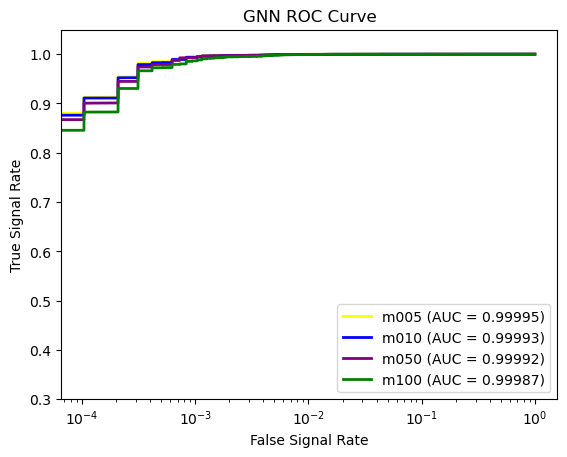

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure()
plt.plot(fpr005, tpr005, color='yellow', lw=2, label=f'm005 (AUC = {roc_auc_005:.5f})')
plt.plot(fpr010, tpr010, color='blue', lw=2, label=f'm010 (AUC = {roc_auc_010:.5f})')
plt.plot(fpr050, tpr050, color='purple', lw=2, label=f'm050 (AUC = {roc_auc_050:.5f})')
plt.plot(fpr100, tpr100, color='green', lw=2, label=f'm100 (AUC = {roc_auc_100:.5f})')
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#plt.xlim([-0.00001, 0.001])
#plt.xlim([0,0.1])
plt.xscale('log')
plt.ylim([0.3, 1.05])
plt.xlabel('False Signal Rate')
plt.ylabel('True Signal Rate')
plt.title('GNN ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig("GNN_roc_curve.png")

In [11]:
#We can compare directly to the BDT:
bdt_fpr005 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_0"]
bdt_tpr005 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_1"]
bdt_auc005 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_2"]

bdt_fpr010 = np.load("bdt_gnn_comp/m010_roc.npz")["arr_0"]
bdt_tpr010 = np.load("bdt_gnn_comp/m010_roc.npz")["arr_1"]
bdt_auc010 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_2"]

bdt_fpr050 = np.load("bdt_gnn_comp/m050_roc.npz")["arr_0"]
bdt_tpr050 = np.load("bdt_gnn_comp/m050_roc.npz")["arr_1"]
bdt_auc050 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_2"]

bdt_fpr100 = np.load("bdt_gnn_comp/m100_roc.npz")["arr_0"]
bdt_tpr100 = np.load("bdt_gnn_comp/m100_roc.npz")["arr_1"]
bdt_auc100 = np.load("bdt_gnn_comp/m005_roc.npz")["arr_2"]

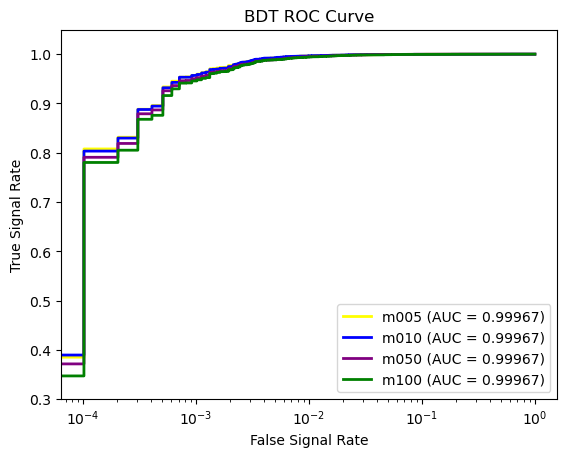

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure()
plt.plot(bdt_fpr005, bdt_tpr005, color='yellow', lw=2, label=f'm005 (AUC = {bdt_auc005:.5f})')
plt.plot(bdt_fpr010, bdt_tpr010, color='blue', lw=2, label=f'm010 (AUC = {bdt_auc010:.5f})')
plt.plot(bdt_fpr050, bdt_tpr050, color='purple', lw=2, label=f'm050 (AUC = {bdt_auc050:.5f})')
plt.plot(bdt_fpr100, bdt_tpr100, color='green', lw=2, label=f'm100 (AUC = {bdt_auc100:.5f})')
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#plt.xlim([-0.00001, 0.001])
#plt.xlim([0,0.1])
plt.xscale('log')
plt.ylim([0.3, 1.05])
plt.xlabel('False Signal Rate')
plt.ylabel('True Signal Rate')
plt.title('BDT ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig("BDT_roc_curve.png")

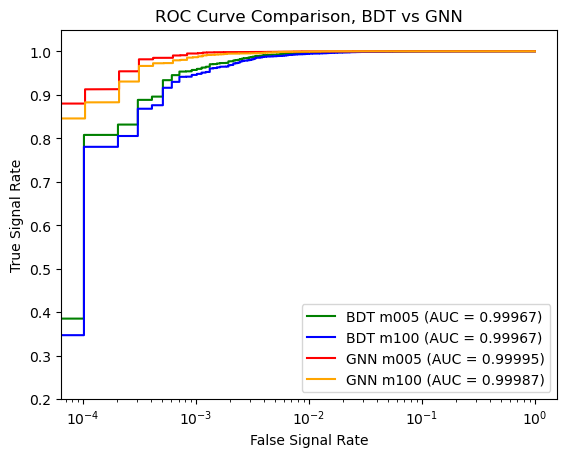

In [54]:
plt.plot(bdt_fpr005, bdt_tpr005, color='green', lw=1.5, label=f'BDT m005 (AUC = {bdt_auc005:.5f})')
plt.plot(bdt_fpr100, bdt_tpr100, color='blue', lw=1.5, label=f'BDT m100 (AUC = {bdt_auc100:.5f})')
plt.plot(fpr005, tpr005, color='red', lw=1.5, label=f'GNN m005 (AUC = {roc_auc_005:.5f})')
plt.plot(fpr100, tpr100, color='orange', lw=1.5, label=f'GNN m100 (AUC = {roc_auc_100:.5f})')
plt.xscale('log')
plt.ylim([0.2, 1.05])
plt.title("ROC Curve Comparison, BDT vs GNN")
plt.xlabel("False Signal Rate")
plt.ylabel("True Signal Rate")
plt.legend()
plt.savefig("BDT_and_GNN_roc_curve.png")

In [11]:
#Now lets do GNN scores plot:
m010_gnn_scores = []
m100_gnn_scores = []
m005_gnn_scores = []
m050_gnn_scores = []
bkgd_gnn_scores = []

with torch.no_grad():
    for data in m010_gnnout_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        m010_gnn_scores.append(probs.cpu())

    for data in m050_gnnout_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        m050_gnn_scores.append(probs.cpu())

    for data in m100_gnnout_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        m100_gnn_scores.append(probs.cpu())

    for data in m005_gnnout_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        m005_gnn_scores.append(probs.cpu())

    for data in bkgd_gnnout_sample_loader:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        bkgd_gnn_scores.append(probs.cpu())

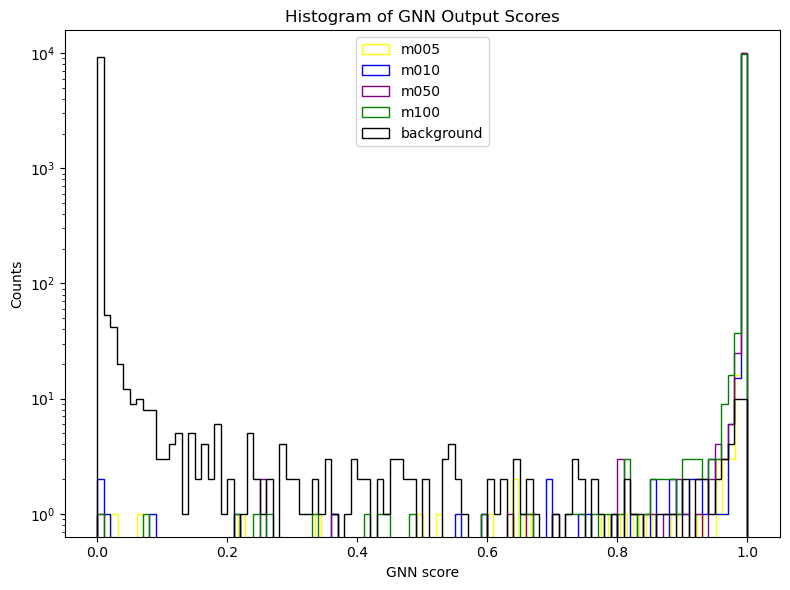

In [12]:
m010 = torch.cat(m010_gnn_scores).numpy()
m050 = torch.cat(m050_gnn_scores).numpy()
m100 = torch.cat(m100_gnn_scores).numpy()
m005 = torch.cat(m005_gnn_scores).numpy()
bkgd = torch.cat(bkgd_gnn_scores).numpy()

plt.figure(figsize=(8,6))

plt.hist(m005, bins=100, histtype="step", edgecolor = 'yellow', label="m005")
plt.hist(m010, bins=100, histtype="step", edgecolor = 'blue', label="m010")
plt.hist(m050, bins=100, histtype="step", edgecolor = 'purple', label="m050")
plt.hist(m100, bins=100, histtype="step", edgecolor = 'green', label="m100")
plt.hist(bkgd, bins=100, histtype="step", edgecolor = 'black', label="background")

plt.xlabel("GNN score")
plt.yscale('log')
plt.ylabel("Counts")
plt.title("Histogram of GNN Output Scores")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
m050_bkgd_roc_sample[-4].x[0]

In [ ]:
m050_bkgd_roc_sample[-1].y[0]

In [ ]:
m010 = torch.cat(m010_gnn_scores).numpy()
m050 = torch.cat(m050_gnn_scores).numpy()
m100 = torch.cat(m100_gnn_scores).numpy()
m005 = torch.cat(m005_gnn_scores).numpy()
bkgd = torch.cat(bkgd_gnn_scores).numpy()

plt.figure(figsize=(8,6))
plt.xlim(0.99,1)
plt.hist(m005, bins=5000, histtype="step", edgecolor = 'yellow', label="m005")
plt.hist(m010, bins=5000, histtype="step", edgecolor = 'blue', label="m010")
plt.hist(m050, bins=5000, histtype="step", edgecolor = 'purple', label="m050")
plt.hist(m100, bins=5000, histtype="step", edgecolor = 'green', label="m100")
plt.hist(bkgd, bins=5000, histtype="step", edgecolor = 'black', label="background")

plt.xlabel("GNN score")
plt.yscale('log')
plt.ylabel("Counts")
plt.title("Histogram of GNN Output Scores")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
max(bkgd)

In [ ]:
sum(m100 > 0.9996917)

In [ ]:
#Independent validation (just to make sure)
#We have more files now! Let's do a tally of what we have
SEED = 2026
np.random.seed(SEED)    # Setting the seed for reproducibility
torch.manual_seed(SEED)
signal_file_directory = '/scratch/wer2ct/November2025/processed/'
batch3_signal_file_paths = glob.glob(os.path.join(signal_file_directory, "batch3*")) #~20k per mass point

#load in our graphs -- this takes some time and memory!
#load in batch1 
batch3_list = []
for path in batch3_signal_file_paths:
    batch3_list.append(torch.load(path, weights_only = False))
    print(f"loaded {path}")

In [ ]:
m010_roc_sample_ind = batch3_list[1][0:10000]
m005_roc_sample_ind = batch3_list[2][0:10000]
m100_roc_sample_ind = batch3_list[0][0:10000]
m050_roc_sample_ind = batch3_list[3][0:10000]

In [ ]:
#load in the second batch of background
bkgd_file_directory = '/scratch/wer2ct/November2025/background_graphs_batch2/processed/'
bkgd_file_paths = glob.glob(os.path.join(bkgd_file_directory, "*.pt")) 
bkgd_datasets_list = []
len(bkgd_file_paths)
for i, path in enumerate(bkgd_file_paths):
    bkgd_datasets_list.append(torch.load(path, weights_only = False))
    if i % 10 == 0:
        print(f"loaded file {i}") 

In [ ]:
bkgd_ind_val_sample = bkgd_datasets_list[80:85] #well outside training range. 

In [ ]:
#We need to declare a bunch of loaders here. This is terribly inefficient but I'm tired
m050_bkgd_roc_sample_ind = bkgd_ind_val_sample[0]+bkgd_ind_val_sample[1]+bkgd_ind_val_sample[2]+bkgd_ind_val_sample[3]+bkgd_ind_val_sample[4]+ m050_roc_sample_ind
m050_roc_sample_loader_ind = DataLoader(m050_bkgd_roc_sample_ind, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

m005_bkgd_roc_sample_ind = bkgd_ind_val_sample[0]+bkgd_ind_val_sample[1]+bkgd_ind_val_sample[2]+bkgd_ind_val_sample[3]+bkgd_ind_val_sample[4]+ m005_roc_sample_ind
m005_roc_sample_loader_ind = DataLoader(m005_bkgd_roc_sample_ind, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

m010_bkgd_roc_sample_ind = bkgd_ind_val_sample[0]+bkgd_ind_val_sample[1]+bkgd_ind_val_sample[2]+bkgd_ind_val_sample[3]+bkgd_ind_val_sample[4]+ m010_roc_sample_ind
m010_roc_sample_loader_ind = DataLoader(m010_bkgd_roc_sample_ind, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

m100_bkgd_roc_sample_ind = bkgd_ind_val_sample[0]+bkgd_ind_val_sample[1]+bkgd_ind_val_sample[2]+bkgd_ind_val_sample[3]+bkgd_ind_val_sample[4]+ m100_roc_sample_ind
m100_roc_sample_loader_ind = DataLoader(m100_bkgd_roc_sample_ind, batch_size = 500, drop_last = True, shuffle=True, num_workers=1)

In [ ]:
#Create our fpr and tpr for ROC curve 
y_scores_m010 = []
y_true_m010 = []

y_scores_m005 = []
y_true_m005 = []

y_scores_m100 = []
y_true_m100 = []

y_scores_m050 = []
y_true_m050 = []

print(f"Using device: {device} ({num_gpus} GPUs available)")

with torch.no_grad():
    for data in m010_roc_sample_loader_ind:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m010.append(probs.cpu())
        y_true_m010.append(data.y.cpu())

    for data in m005_roc_sample_loader_ind:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m005.append(probs.cpu())
        y_true_m005.append(data.y.cpu())

    for data in m100_roc_sample_loader_ind:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m100.append(probs.cpu())
        y_true_m100.append(data.y.cpu())

    for data in m050_roc_sample_loader_ind:
        # Move batch to GPU
        data = data.to(device)

        # Forward pass on GPU
        out = model_preloaded(data.x, data.edge_index, data.batch)

        # Assuming binary classification and out shape [N, 2]
        probs = torch.softmax(out, dim=1)[:, 1]

        # Only CPU when appending
        y_scores_m050.append(probs.cpu())
        y_true_m050.append(data.y.cpu())

y_true_m010 = torch.cat(y_true_m010).numpy()
y_scores_m010 = torch.cat(y_scores_m010).numpy()

y_true_m005 = torch.cat(y_true_m005).numpy()
y_scores_m005 = torch.cat(y_scores_m005).numpy()

y_true_m100 = torch.cat(y_true_m100).numpy()
y_scores_m100 = torch.cat(y_scores_m100).numpy()

y_true_m050 = torch.cat(y_true_m050).numpy()
y_scores_m050 = torch.cat(y_scores_m050).numpy()

fpr005, tpr005, thresholds005 = roc_curve(y_true_m005, y_scores_m005)
roc_auc_005 = auc(fpr005, tpr005)

fpr050, tpr050, thresholds050 = roc_curve(y_true_m050, y_scores_m050)
roc_auc_050 = auc(fpr050, tpr050)

fpr010, tpr010, thresholds010 = roc_curve(y_true_m010, y_scores_m010)
roc_auc_010 = auc(fpr010, tpr010)

fpr100, tpr100, thresholds100 = roc_curve(y_true_m100, y_scores_m100)
roc_auc_100 = auc(fpr100, tpr100)

In [ ]:
plt.figure()
plt.plot(fpr005, tpr005, color='yellow', lw=2, label=f'm005 (AUC = {roc_auc_005:.5f})')
plt.plot(fpr010, tpr010, color='blue', lw=2, label=f'm010 (AUC = {roc_auc_010:.5f})')
plt.plot(fpr050, tpr050, color='purple', lw=2, label=f'm050 (AUC = {roc_auc_050:.5f})')
plt.plot(fpr100, tpr100, color='green', lw=2, label=f'm100 (AUC = {roc_auc_100:.5f})')
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.00001, 0.001])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for GNN')
plt.legend(loc="lower right")
plt.show()